## Import packages

In [ ]:
# run this cell, then restart the runtime before continuing
!pip install git+https://github.com/joeddav/transformers
!pip install nlp
!pip install transformers==4.15.0 # Esto lo puse porque la última versión de transformers, la 4.27.0 rompe con otro paquete.
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.
!pip install ray[tune]

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from nlp import load_dataset
import torch
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,f1_score
from sklearn.model_selection import train_test_split
import pickle
from google.colab import files
src = list(files.upload().values())[0]
open('transformers_tools.py','wb').write(src)

Saving transformers_tools.py to transformers_tools (1).py


4525

In [4]:
from transformers_tools import *
import html
from html import unescape
import re
import random

In [5]:
random.seed(10)

In [6]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [7]:
def finetune(train,val,epoc,lr, output_file_path=None):
    training_args = TrainingArguments(
      output_dir='./results',
      num_train_epochs=epoc,
      per_device_train_batch_size=10, ## pick the biggest batch size we can fit
      per_device_eval_batch_size=10,
      warmup_steps=500,
      weight_decay=0.01,
      learning_rate = lr,#2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
      logging_dir='./logs',
      seed = 123)

    trainer = Trainer(
      model=model,
      args=training_args,
      compute_metrics=compute_metrics,
      train_dataset=train,
      eval_dataset=val
  )

    trainer.train()
    if output_file_path is not None:
        print('saving model to ',output_file_path)
        model.save_pretrained(output_file_path)
        tokenizer.save_pretrained(output_file_path)

    return trainer.evaluate()

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    return {
        'accuracy': acc,
        'f1': f1,
        'f1 macro': f1_macro,
        'precision': precision,
        'recall': recall
    }

# Training

## Prepare data

### Train data

In [9]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
%pwd

'/content'

In [11]:
path = "/content/gdrive/MyDrive/TESIS/"

In [12]:
train = pd.read_excel(path + "data/transformer_input.xlsx", sheet_name = 'train')
val_data = pd.read_excel(path + "data/transformer_input.xlsx", sheet_name = 'val')
test_data = pd.read_excel(path + "data/transformer_input.xlsx", sheet_name = 'test')
adversarial = pd.read_excel(path + "data/transformer_input.xlsx", sheet_name = 'adversarial')
train_arg = pd.read_excel(path + "data/transformer_input.xlsx", sheet_name = 'argentina')#, encoding='utf-8')

In [13]:
print('Train data',train.shape)
print('Validation',val_data.shape)
print('Test',test_data.shape)
print('Adversarial',adversarial.shape)
print('Argentina',train_arg.shape)

Train data (5896, 4)
Validation (1124, 4)
Test (1980, 4)
Adversarial (1639, 3)
Argentina (1801, 4)


In [14]:
train_data = train_arg.append([train]) #
#train_data = train_arg.append([train]) #
train_data.head()

<ipython-input-14-fc5756420ee8>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_arg.append([train]) #


,id,replaced_text,abuse,seed_target,round
0,id_1435451994718842881,@Politica_token Es un absurdo monumental inclu...,0,1.0,NaN
1,id_1435450898772279296,@Politica_token dejá de gastar dinero del esta...,1,1.0,NaN
2,id_1435450009412153345,@Politica_token @USER @Politica_token @USER Ra...,1,1.0,NaN
3,id_1435449210862809093,Goce y disfrute. Tenemos récord de muertos por...,1,1.0,NaN
4,id_1435445822930530304,@Politica_token @USER @Politica_token @USER Se...,0,1.0,NaN


In [15]:
train_data.abuse = train_data.abuse.astype(int)
val_data.abuse = val_data.abuse.astype(int)
test_data.abuse = test_data.abuse.astype(int)

In [16]:
train_data.shape

(7697, 5)

In [17]:
val_data.shape

(1124, 4)

In [18]:
train_texts = list(train_data.replaced_text.values)
train_labels = list(train_data.abuse.values)
val_texts = list(val_data.replaced_text.values)
val_labels = list(val_data.abuse.values)
test_texts = list(test_data.replaced_text.values)
test_labels = list(test_data.abuse.values)

In [19]:
len(train_texts)

7697

In [20]:
len(train_labels)

7697

In [21]:
model_path = "/content/gdrive/MyDrive/Tesis_Maestria/classifier/"

In [24]:
aa = train_data.append([val_data, test_data])

<ipython-input-24-1c10ea61a8df>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aa = train_data.append([val_data, test_data])


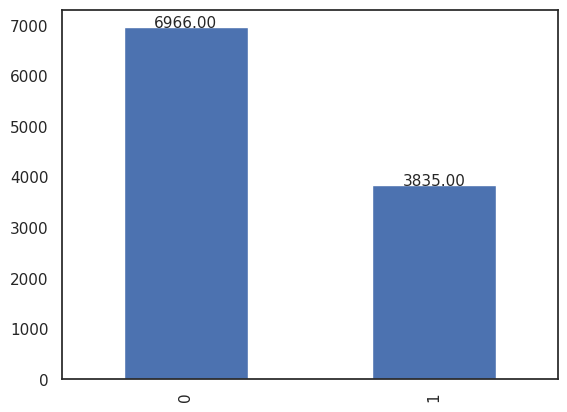

In [ ]:
import seaborn as sns
sns.set(style='white')
ax = aa.abuse.value_counts().plot.bar()
for bar in ax.patches:
  ax.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=11, xytext=(0, 3), textcoords='offset points')

## Train classifier

### BETO

In [23]:
### Load model and tokenizer
### Pretrained models come with their own tokenizer
from transformers import BertForSequenceClassification, BertTokenizerFast
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased') #
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [24]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
#test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [25]:
train_dataset = TrainDataset(train_encodings, train_labels)
val_dataset = TrainDataset(val_encodings, val_labels)

In [26]:
final_model = finetune(train_dataset, val_dataset, 3, 2e-05,output_file_path=model_path)

***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


Step,Training Loss
500,0.594400
1000,0.438000
1500,0.370000
2000,0.206200


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/config.json


saving model to  /content/gdrive/MyDrive/Tesis_Maestria/classifier/


Model weights saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1124
  Batch size = 10


In [ ]:
resultados = []
for i in range(0,10):
  final_model = finetune(train_dataset, val_dataset, 3, 2e-05,output_file_path=model_path)
  print(final_model)
  resultados.append(final_model)

In [ ]:
resultados

[{'eval_loss': 1.424133539199829,
  'eval_accuracy': 0.7864768683274022,
  'eval_f1': 0.6610169491525424,
  'eval_f1 macro': 0.7525863966541932,
  'eval_precision': 0.6724137931034483,
  'eval_recall': 0.65,
  'eval_runtime': 8.581,
  'eval_samples_per_second': 130.988,
  'eval_steps_per_second': 13.169,
  'epoch': 3.0},
 {'eval_loss': 1.6106154918670654,
  'eval_accuracy': 0.7891459074733096,
  'eval_f1': 0.6775510204081633,
  'eval_f1 macro': 0.7604542940771815,
  'eval_precision': 0.664,
  'eval_recall': 0.6916666666666667,
  'eval_runtime': 8.5199,
  'eval_samples_per_second': 131.926,
  'eval_steps_per_second': 13.263,
  'epoch': 3.0},
 {'eval_loss': 1.6279417276382446,
  'eval_accuracy': 0.7909252669039146,
  'eval_f1': 0.6676096181046676,
  'eval_f1 macro': 0.7575556202139171,
  'eval_precision': 0.6801152737752162,
  'eval_recall': 0.6555555555555556,
  'eval_runtime': 8.4836,
  'eval_samples_per_second': 132.492,
  'eval_steps_per_second': 13.32,
  'epoch': 3.0},
 {'eval_loss'

### ROBERTA

In [ ]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
tokenizer = RobertaTokenizerFast.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
model = RobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')

C:\Users\Pluvini\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pluvini\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [ ]:
resultados_roberta = []
for i in range(0,5):
  final_model = finetune(train_dataset, val_dataset, 3, 2e-05,output_file_path=model_path)
  print(final_model)
  resultados_roberta.append(final_model)
resultados_roberta

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


Step,Training Loss
500,0.563300
1000,0.398000
1500,0.301900
2000,0.102200


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/config.json


saving model to  /content/gdrive/MyDrive/Tesis_Maestria/classifier/


Model weights saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1124
  Batch size = 10


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


{'eval_loss': 0.9526160955429077, 'eval_accuracy': 0.7882562277580071, 'eval_f1': 0.6638418079096046, 'eval_f1 macro': 0.7546481766820751, 'eval_precision': 0.6752873563218391, 'eval_recall': 0.6527777777777778, 'eval_runtime': 21.0947, 'eval_samples_per_second': 53.283, 'eval_steps_per_second': 5.357, 'epoch': 3.0}


Step,Training Loss
500,0.055700
1000,0.099400
1500,0.069300
2000,0.021200


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/config.json


saving model to  /content/gdrive/MyDrive/Tesis_Maestria/classifier/


Model weights saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1124
  Batch size = 10


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


{'eval_loss': 1.3310396671295166, 'eval_accuracy': 0.7953736654804271, 'eval_f1': 0.6823204419889503, 'eval_f1 macro': 0.7657009034091733, 'eval_precision': 0.6785714285714286, 'eval_recall': 0.6861111111111111, 'eval_runtime': 21.2596, 'eval_samples_per_second': 52.87, 'eval_steps_per_second': 5.315, 'epoch': 3.0}


Step,Training Loss
500,0.027200
1000,0.092200
1500,0.061000
2000,0.018100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/config.json


saving model to  /content/gdrive/MyDrive/Tesis_Maestria/classifier/


Model weights saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1124
  Batch size = 10


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


{'eval_loss': 1.6530230045318604, 'eval_accuracy': 0.7740213523131673, 'eval_f1': 0.6422535211267606, 'eval_f1 macro': 0.7385519881316507, 'eval_precision': 0.6514285714285715, 'eval_recall': 0.6333333333333333, 'eval_runtime': 21.0251, 'eval_samples_per_second': 53.46, 'eval_steps_per_second': 5.375, 'epoch': 3.0}


Step,Training Loss
500,0.030500
1000,0.076100
1500,0.050400
2000,0.017100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/config.json


saving model to  /content/gdrive/MyDrive/Tesis_Maestria/classifier/


Model weights saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/Tesis_Maestria/classifier/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1124
  Batch size = 10


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


{'eval_loss': 1.5561916828155518, 'eval_accuracy': 0.7909252669039146, 'eval_f1': 0.6657183499288764, 'eval_f1 macro': 0.756807395029163, 'eval_precision': 0.6822157434402333, 'eval_recall': 0.65, 'eval_runtime': 21.029, 'eval_samples_per_second': 53.45, 'eval_steps_per_second': 5.374, 'epoch': 3.0}


Step,Training Loss
500,0.026300
1000,0.052600
1500,0.051800


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin


### ELECTRA

In [22]:
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast

model = ElectraForSequenceClassification.from_pretrained("mrm8488/electricidad-base-discriminator")
tokenizer = ElectraTokenizerFast.from_pretrained("mrm8488/electricidad-base-discriminator")

Some weights of the model checkpoint at mrm8488/electricidad-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at mrm8488/electricidad-base-discriminator and are newly initialized: ['

In [34]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [35]:
train_dataset = TrainDataset(train_encodings, train_labels)
val_dataset = TrainDataset(val_encodings, val_labels)

In [ ]:
resultados_electra = []
for i in range(0,5):
  final_model = finetune(train_dataset, val_dataset, 3, 2e-05,output_file_path=model_path)
  print(final_model)
  resultados_electra.append(final_model)
resultados_electra

### BERTIN

In [27]:
tokenizer = AutoTokenizer.from_pretrained('bertin-project/bertin-roberta-base-spanish')
model = AutoModelForSequenceClassification.from_pretrained("bertin-project/bertin-roberta-base-spanish")

https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcxyby490


Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

storing https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/72bf61c243630a112d8fa8c8d9162f1a5e01fab0602d2f2a7792cecdc0a4986f.a92abca7d07376fc2376db92d7f060b988d915ef9b2981c5616603a86c340fa0
creating metadata file for /root/.cache/huggingface/transformers/72bf61c243630a112d8fa8c8d9162f1a5e01fab0602d2f2a7792cecdc0a4986f.a92abca7d07376fc2376db92d7f060b988d915ef9b2981c5616603a86c340fa0
https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpk7ytcmd6


Downloading:   0%|          | 0.00/831k [00:00<?, ?B/s]

storing https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/f47efb87887425ef9a4ef795bfaa907d57ac9a650d733c7ca621b9eced3235e8.0b968504b15b2f5e6e9e491723f31987782cb976064aff9a7c6188cc2d5ce8bc
creating metadata file for /root/.cache/huggingface/transformers/f47efb87887425ef9a4ef795bfaa907d57ac9a650d733c7ca621b9eced3235e8.0b968504b15b2f5e6e9e491723f31987782cb976064aff9a7c6188cc2d5ce8bc
https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpo10c6wap


Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

storing https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/aba9e0895dea47dd4208a36012ffd3eb21eb4c5f7ce0be6547afb37cdd4ddef4.0d24ae8bd5fabb1f5020f91bc602cefeb5a2938ab77e21769d28776345634b23
creating metadata file for /root/.cache/huggingface/transformers/aba9e0895dea47dd4208a36012ffd3eb21eb4c5f7ce0be6547afb37cdd4ddef4.0d24ae8bd5fabb1f5020f91bc602cefeb5a2938ab77e21769d28776345634b23
https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp91uz8wtv


Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

storing https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/baad57d0f574d3e660cafb14601d0ecebe83f25071d59f3e51d225d75285b773.23862d4cf295978aaf1f42b721fda2d8ece45b112d21f0c83905e5b05454e440
creating metadata file for /root/.cache/huggingface/transformers/baad57d0f574d3e660cafb14601d0ecebe83f25071d59f3e51d225d75285b773.23862d4cf295978aaf1f42b721fda2d8ece45b112d21f0c83905e5b05454e440
https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_rbybej0


Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

storing https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/68d1fdfe72fdcac403d8f363239c379d8125162f50a954030c4476982f88d69e.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0
creating metadata file for /root/.cache/huggingface/transformers/68d1fdfe72fdcac403d8f363239c379d8125162f50a954030c4476982f88d69e.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0
loading file https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/f47efb87887425ef9a4ef795bfaa907d57ac9a650d733c7ca621b9eced3235e8.0b968504b15b2f5e6e9e491723f31987782cb976064aff9a7c6188cc2d5ce8bc
loading file https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/aba9e0895dea47dd4208a36012ffd3eb21eb4c5f7ce0be6547afb37cdd4ddef4.0d24ae8bd

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

storing https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/aa24361f0b7bed62876f6cd0a784a2b622c1959523906d89eeb1112139a4864a.604375914a974f33506fc8902fe2d195407cbf2316166e695267dd5655a736b3
creating metadata file for /root/.cache/huggingface/transformers/aa24361f0b7bed62876f6cd0a784a2b622c1959523906d89eeb1112139a4864a.604375914a974f33506fc8902fe2d195407cbf2316166e695267dd5655a736b3
loading configuration file https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/aa24361f0b7bed62876f6cd0a784a2b622c1959523906d89eeb1112139a4864a.604375914a974f33506fc8902fe2d195407cbf2316166e695267dd5655a736b3
Model config RobertaConfig {
  "_name_or_path": "bertin-project/bertin-roberta-base-spanish",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

storing https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8a611c8e6ab409ea523e84173bef4b1ef257262487d732b05c68d31b674788e5.3d29e87c548fd02d0f2d5ab15d107cbea809ddca733efe9433377f48b557ee72
creating metadata file for /root/.cache/huggingface/transformers/8a611c8e6ab409ea523e84173bef4b1ef257262487d732b05c68d31b674788e5.3d29e87c548fd02d0f2d5ab15d107cbea809ddca733efe9433377f48b557ee72
loading weights file https://huggingface.co/bertin-project/bertin-roberta-base-spanish/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8a611c8e6ab409ea523e84173bef4b1ef257262487d732b05c68d31b674788e5.3d29e87c548fd02d0f2d5ab15d107cbea809ddca733efe9433377f48b557ee72
Some weights of the model checkpoint at bertin-project/bertin-roberta-base-spanish were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weig

In [28]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
train_dataset = TrainDataset(train_encodings, train_labels)
val_dataset = TrainDataset(val_encodings, val_labels)

In [29]:
model_path = '/content/gdrive/MyDrive/TESIS/classifier/'

In [ ]:
resultados_bertin = []
for i in range(0,5):
  final_model = finetune(train_dataset, val_dataset, 3, 2e-05,output_file_path=model_path)
  print(final_model)
  resultados_bertin.append(final_model)
resultados_electra

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


Step,Training Loss
500,0.650900
1000,0.521800
1500,0.437900
2000,0.239000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




saving model to  /content/gdrive/MyDrive/TESIS/classifier/


Configuration saved in /content/gdrive/MyDrive/TESIS/classifier/config.json
Model weights saved in /content/gdrive/MyDrive/TESIS/classifier/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/TESIS/classifier/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/TESIS/classifier/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1124
  Batch size = 10


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


{'eval_loss': 0.9675100445747375, 'eval_accuracy': 0.7775800711743772, 'eval_f1': 0.6438746438746438, 'eval_f1 macro': 0.7410835056371925, 'eval_precision': 0.6608187134502924, 'eval_recall': 0.6277777777777778, 'eval_runtime': 21.1623, 'eval_samples_per_second': 53.113, 'eval_steps_per_second': 5.34, 'epoch': 3.0}


Step,Training Loss
500,0.170000
1000,0.187600
1500,0.117000
2000,0.038500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in /content/gdrive/MyDrive/TESIS/classifier/config.json


saving model to  /content/gdrive/MyDrive/TESIS/classifier/


Model weights saved in /content/gdrive/MyDrive/TESIS/classifier/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/TESIS/classifier/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/TESIS/classifier/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1124
  Batch size = 10


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


{'eval_loss': 1.5032063722610474, 'eval_accuracy': 0.7624555160142349, 'eval_f1': 0.638700947225981, 'eval_f1 macro': 0.7308812887223344, 'eval_precision': 0.6226912928759895, 'eval_recall': 0.6555555555555556, 'eval_runtime': 21.245, 'eval_samples_per_second': 52.906, 'eval_steps_per_second': 5.319, 'epoch': 3.0}


Step,Training Loss


In [1]:
resultados_bertin

NameError: ignored

### ROBERTUITO

In [31]:
inputs = tokenizer("Hola, ¿cómo estás?", return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[0.4995, 0.1723]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [30]:
tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-base-uncased', truncation=True, padding=True, max_length=512)
model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-base-uncased")

loading file https://huggingface.co/pysentimiento/robertuito-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/pysentimiento/robertuito-base-uncased/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7677b28e4f4fa098e430ed267e778564be9f6018f1345ccdc31beca2e92133a6.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/pysentimiento/robertuito-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/74a7741e4205e32e1912beaaf29eccd8217ffe0df602aa9aeeeb93ab864f64a0.dee0dc8e8c4faa7c1ddf41f39d8e9c2de137a25062f44be5343911543b88278a
loading file https://huggingface.co/pysentimiento/robertuito-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/af1e0c71fd33ab1edd7e911e1eb7dd11acd0571db76101f42e8fddb3950824d6.c61b8b3a1d74525441ce91bdaf6f074e6da7f13a7df188bdb21f7d03eef018b0
loading 

In [31]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length = 512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length = 512) 
train_dataset = TrainDataset(train_encodings, train_labels)
val_dataset = TrainDataset(val_encodings, val_labels)

In [32]:
resultados_robertuito = []
for i in range(0,5):
    print(i)
    final_model = finetune(train_dataset, val_dataset, 3, 2e-05,output_file_path=model_path)
    print(final_model)
    resultados_robertuito.append(final_model)
resultados_robertuito

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2310


0


Step,Training Loss


RuntimeError: ignored

In [36]:
final_model = finetune(train_dataset, val_dataset, 3, 2e-05,output_file_path=model_path)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 7697
  Num Epochs = 3
  Instantaneous batch size per device = 30
  Total train batch size (w. parallel, distributed & accumulation) = 30
  Gradient Accumulation steps = 1
  Total optimization steps = 771


Step,Training Loss


IndexError: ignored